### Validation figure [transect]
#### - This is an adaptation of Fig. 3. I am making a temperature transect north-south through the slope  with ispycnals overlaid and comparing that to WOA18 climatology. 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cftime
import glob,os
import matplotlib.colors as col
import xarray.ufuncs as xu
import gsw
import pandas as pd

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
from glob import glob     #or else you get an error when trying to load the WOA files

##added a bunch of those trying to make things work, so some of these packages might not be needed anymore.
from matplotlib.cm import ScalarMappable
from scipy.interpolate import interp1d
from scipy import interpolate

# set to your figure directory location:
#figdir = '/g/data/v45/akm157/figures/Antarctic_tides_fixed/temp_transect_movie/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40899,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:43537,Total threads: 4
Dashboard: /proxy/39315/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:39057,


### LOAD MODEL DATA

### 2004-2018 to compare with seals

In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
cycle3 = '01deg_jra55v140_iaf_cycle3'
##initially I calculated the model just for 2012, but after having a look on what sort of data the seals had, I decided to do all months from 2004-2018,
## so we would be covering the same period on both
first_year = '2004'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# set this to the rough region of interest:
lon_slice  = slice(-258, -248)
lat_slice  = slice(-67.5, -61)

In [4]:
# get temp and salt to calculate lines:
temp = cc.querying.getvar(cycle3,'temp',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly') - 273.15
temp = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

salt = cc.querying.getvar(cycle3,'salt',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
salt = salt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [5]:
temp = temp.load()
salt = salt.load()


#### Plot map of chosen transect

In [6]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
temp_slice = temp.sel(st_ocean=400,method='nearest').mean('time')
temp_slice = temp_slice.load()

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

Text(0, 0.5, 'Latitude ($^\\circ$)')

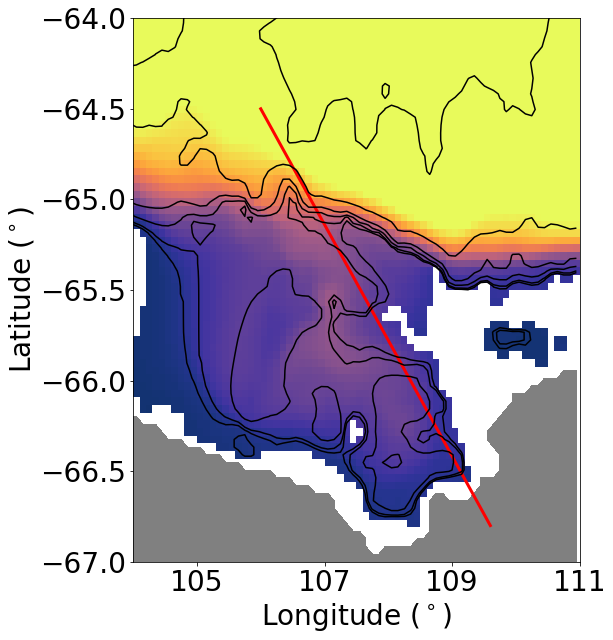

In [7]:
## define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -66.8
lat1=  -64.5
lon0 = -249.4
lon1 = -253 #-254



fontsize=28

fig=plt.figure(figsize=(10,10))
ax0=plt.subplot(1,1,1)  
# plot temperature:
plt.pcolormesh(temp_slice.xt_ocean,temp_slice.yt_ocean,temp_slice, cmap=cmocean.thermal,
              vmin=-2,vmax=0)
cbar=plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r',linewidth='3')
plt.xlim((-255, -248))
plt.ylim((-67, -64))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[500,550,700,1000,2000,3000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.tick_params(labelsize=fontsize)

cbar.ax.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'Temperature ($^\circ$C)', fontsize = 18,labelpad=5)
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-256+359,-254+359,-252+359,-250+359,-248+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
#filestr = figdir+'/SI_map_validation_transect_model.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [8]:
#temp

### extract nearest points along transect 

In [9]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
#this is wrong for salt and T because I have avg them

lons = [lon0, lon1]
lats = [lat0, lat1]

yt_ocean = temp.yt_ocean

# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yt_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yt_ocean')

# Extract temp and salt along transect:
temp_transect = temp.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
salt_transect = salt.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')

# bathymetry along transect:
ht_transect = ht.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
ht_transect = ht_transect.fillna(0)

# calculate density along transect:
# arrays for gsw to use
depth_array = temp_transect*0 + temp_transect.st_ocean
lat_array = temp_transect*0 + temp_transect.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(salt_transect,pressure,lon_transect,lat_array)
sigma0 = gsw.sigma0(salt_abs,temp_transect)
# convert back to xarray for multiplying later:
sigma0 = xr.DataArray(sigma0,
                      coords = [temp_transect.time, temp_transect.st_ocean,temp_transect.yt_ocean],
                      dims = ['time','st_ocean','yt_ocean'])

In [10]:
# averaging data to get a year product
sigma0=sigma0.mean('time')
temp_transect=temp_transect.mean('time')
sal_transect=salt_abs.mean('time')

In [11]:
# load data before plotting:
temp_transect = temp_transect.load()
sal_transect = sal_transect.load()

In [12]:
# load data before plotting:
sigma0 = sigma0.load()

#### LOAD SEALS 

In [13]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-255, -247)
lat_slice  = slice(-75.5,-60)

In [14]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(control,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

## Get model grid data and temperature climatology:

In [15]:
# for comparing seal data to IAF:
iaf = '01deg_jra55v140_iaf_cycle3'

start_time='2012-01-01'
end_time='2012-12-31'

temp_con = cc.querying.getvar(iaf,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)                          
#temp_con = temp_con.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_con = temp_con[:,:50,:,:]
temp_con = temp_con.load()

In [16]:
xt_ocean = temp_con.xt_ocean
yt_ocean = temp_con.yt_ocean
st_ocean = temp_con.st_ocean

## Select out profiles in correct region:

#### Improvements on this figure: take out winter profiles, sort profiles 
#### Fix it in a way they don't go much shallower than 400m. 

In [17]:
%%time
# do some testing to see which seal data is in the right region:
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/v45/ns3783/scripts/seal_data/'
FileList = glob(path2files+'*.nc')
FileList.sort()

WAP_FileList = []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in West Antarctic Peninsula box:
    WAP_box=lat.where(lon>104).where(lon<114).where(lat<-60).dropna(dim='N_PROF')
    if len(WAP_box)>0:
        WAP_FileList += [file]

CPU times: user 23.7 s, sys: 4.18 s, total: 27.9 s
Wall time: 45.3 s


In [18]:
np.shape(WAP_FileList)

(58,)

In [19]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:

nprofiles = 29496 # tested with one run / so this is all good. I know this is the right number for this dataset
ndepth = 1000 #although I have downloaded the profiles with no interpolation, some might have been interpolated because it doesn't run with less than 1000 levels
temp = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
sal = np.zeros((nprofiles,ndepth))

lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
#date_obs = np.zeros((nprofiles)) 
year_obs = np.zeros((nprofiles))
month_obs = np.zeros((nprofiles))

profile_count = 0

file_count = 1
for file in WAP_FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    juld = profile_data.JULD
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        temp_profile = profile_data.TEMP_ADJUSTED[profile]
        sal_profile = profile_data.PSAL_ADJUSTED[profile]
        if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
            # check the dive reached at least 200 dbar:
            pres_profile = profile_data.PRES_ADJUSTED[profile]
            if pres_profile.max() > 200:
                date = np.append(date,profile_data.JULD[profile])
                #date_obs[profile_count] = date[profile]
                year_obs[profile_count] = profile_data.JULD[profile].dt.year #this is an add on to lock months and years separately
                month_obs[profile_count] = profile_data.JULD[profile].dt.month
                # save profile:
                lat_obs[profile_count] = lat[profile]
                lon_obs[profile_count] = lon[profile]
                # find depth of profile/all levels:
                nlevels = len(profile_data.PRES_ADJUSTED[profile])
                temp[profile_count,:nlevels] = temp_profile
                pres[profile_count,:nlevels] = pres_profile
                sal[profile_count,:nlevels] = sal_profile
                
                profile_count += 1
    file_count += 1

CPU times: user 2min 38s, sys: 11.7 s, total: 2min 50s
Wall time: 2min 40s


## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


In [20]:
# convert to absolute salinity:
from gsw import SA_from_SP
salt_abs = SA_from_SP(sal,pres,np.tile(lon_obs,(ndepth,1)).swapaxes(0,1),np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [21]:
# convert to conservative temp:
from gsw import CT_from_t
temp_conservative = CT_from_t(salt_abs,temp,pres)

In [22]:
# convert pressure to depth:
from gsw import z_from_p
z = -z_from_p(pres,np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [23]:
print('Shape of z_profile:', z.shape)
print('Shape of temp_profile:', temp_conservative.shape)

Shape of z_profile: (29496, 1000)
Shape of temp_profile: (29496, 1000)


In [24]:
%%time
st_ocean = temp_transect.st_ocean
# Only care about on shelf, so just do top 50 levels:
temp_interp_seal = np.zeros((nprofiles, len(st_ocean)))
sal_interp_seal = np.zeros((nprofiles, len(st_ocean)))

for profile in range(nprofiles):
    # select out available pressure range of data:
    pres_profile = z[profile,:][z[profile,:]>0]
    temp_profile = temp_conservative[profile,:][z[profile,:]>0]
    sal_profile = salt_abs[profile,:][z[profile,:]>0]
    # also remove missing temperature points:
    temp_profile_adj = temp_profile[temp_profile!=0]
    sal_profile_adj = sal_profile[temp_profile!=0]
    z_profile_adj = pres_profile[temp_profile!=0]
    
    f = interpolate.interp1d(z_profile_adj,temp_profile_adj,bounds_error=False)
    temp_interp_seal[profile,:] = f(st_ocean)
    
    f = interpolate.interp1d(z_profile_adj,sal_profile_adj,bounds_error=False)
    sal_interp_seal[profile,:] = f(st_ocean)

CPU times: user 12 s, sys: 782 ms, total: 12.8 s
Wall time: 11.9 s


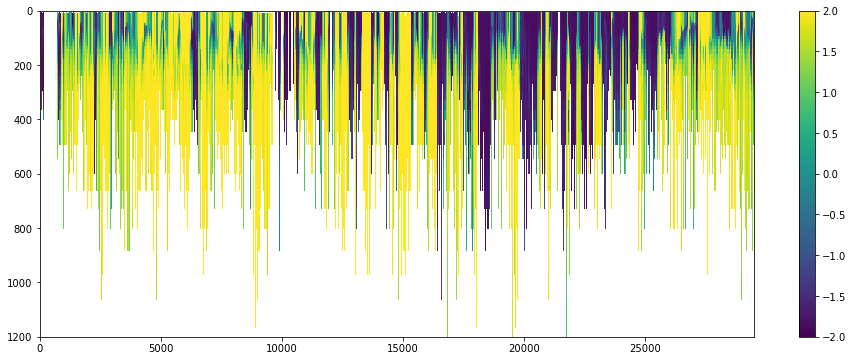

In [25]:
# check profiles look ok:
x_2d,y_2d = np.meshgrid(np.arange(nprofiles),st_ocean)

plt.figure(figsize=(16,6))
plt.pcolormesh(x_2d,y_2d,temp_interp_seal.swapaxes(0,1))
plt.ylim(1200,0)
plt.colorbar()
plt.clim(-2,2)

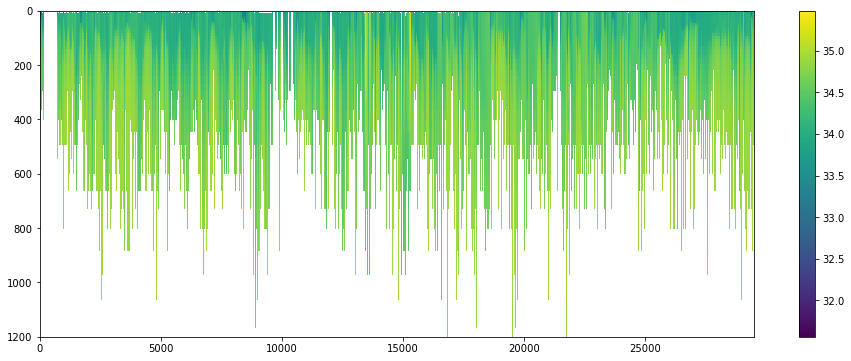

In [26]:
# check profiles look ok:
x_2d,y_2d = np.meshgrid(np.arange(nprofiles),st_ocean)

plt.figure(figsize=(16,6))
plt.pcolormesh(x_2d,y_2d,sal_interp_seal.swapaxes(0,1))
plt.ylim(1200,0)
plt.colorbar()
#plt.clim(-2,2)

### Create DataArrays for the new data

In [27]:
temp_interp_seal = xr.DataArray(temp_interp_seal, coords = [np.arange(nprofiles), st_ocean], dims = ['profile_number', 'st_ocean'], name = 'temp seal profiles interpolated onto model depth grid')
sal_interp_seal = xr.DataArray(sal_interp_seal, coords = [np.arange(nprofiles), st_ocean], dims = ['profile_number', 'st_ocean'], name = 'sal seal profiles interpolated onto model depth grid')
lon_obs = xr.DataArray(lon_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'longitude of seal profiles')
lat_obs = xr.DataArray(lat_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'latitude of seal profiles')
month_obs = xr.DataArray(month_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'month of seal profiles')
year_obs = xr.DataArray(year_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'year of seal profiles')
date = xr.DataArray(date, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'date of seal profiles')

## BIN DATA BEFORE EXTRACTING THE POINTS FOR THE TRANSECT

In [28]:
# need to assign lat/lon coords for binning:
temp_interp_seal = temp_interp_seal.assign_coords({'lon':lon_obs,'lat':lat_obs})
sal_interp_seal = sal_interp_seal.assign_coords({'lon':lon_obs,'lat':lat_obs})

### BIN Temperature data

In [29]:
## set up new bins:
#lon_bins = np.arange(104, 114, .1)
#lat_bins = np.arange(-76, -60, .1) 

# trying a coarser resolution set up new bins:
lon_bins = np.arange(104, 114, .5)
lat_bins = np.arange(-76, -60, .5) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

# full depth:
binned_meop_temp = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), 
                                coords = [st_ocean,lat_mid, lon_mid], 
                                dims = ['st_ocean','lat_bin', 'lon_bin'], 
                                name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = (temp_interp_seal.lon <= lon_bins[i+1]) & (temp_interp_seal.lon > lon_bins[i])\
            & (temp_interp_seal.lat <= lat_bins[j+1]) & (temp_interp_seal.lat > lat_bins[j])
        binned_meop_temp[:,j,i] = (temp_interp_seal.where(bin_mask)).mean(dim = 'profile_number')

lon bin 0/19
lon bin 1/19
lon bin 2/19
lon bin 3/19
lon bin 4/19
lon bin 5/19
lon bin 6/19
lon bin 7/19
lon bin 8/19
lon bin 9/19
lon bin 10/19
lon bin 11/19
lon bin 12/19
lon bin 13/19
lon bin 14/19
lon bin 15/19
lon bin 16/19
lon bin 17/19
lon bin 18/19


### BIN Salinity data

In [30]:
## set up new bins:
#lon_bins = np.arange(104, 114, .1)
#lat_bins = np.arange(-76, -60, .1) 

# trying a coarser resolution set up new bins:
lon_bins = np.arange(104, 114, .5)
lat_bins = np.arange(-76, -60, .5) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

# full depth:
binned_meop_sal = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), 
                                coords = [st_ocean,lat_mid, lon_mid], 
                                dims = ['st_ocean','lat_bin', 'lon_bin'], 
                                name = 'binned meop salinity data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = (sal_interp_seal.lon <= lon_bins[i+1]) & (sal_interp_seal.lon > lon_bins[i])\
            & (sal_interp_seal.lat <= lat_bins[j+1]) & (sal_interp_seal.lat > lat_bins[j])
        binned_meop_sal[:,j,i] = (sal_interp_seal.where(bin_mask)).mean(dim = 'profile_number')

lon bin 0/19
lon bin 1/19
lon bin 2/19
lon bin 3/19
lon bin 4/19
lon bin 5/19
lon bin 6/19
lon bin 7/19
lon bin 8/19
lon bin 9/19
lon bin 10/19
lon bin 11/19
lon bin 12/19
lon bin 13/19
lon bin 14/19
lon bin 15/19
lon bin 16/19
lon bin 17/19
lon bin 18/19


### Define transect start and end points: 

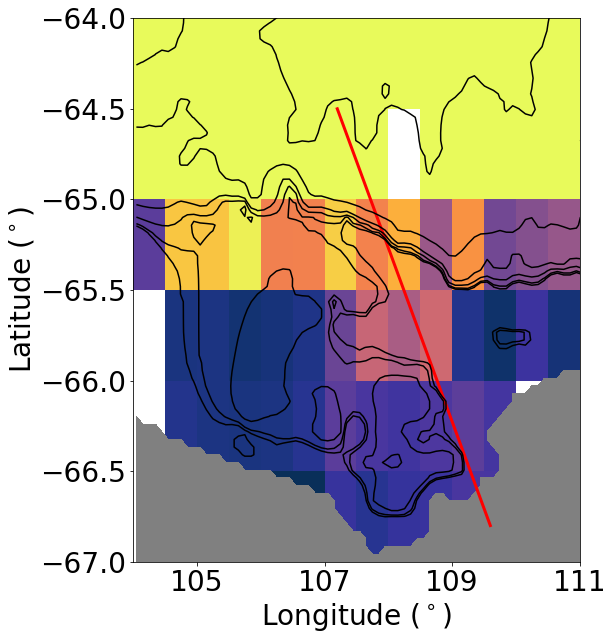

In [31]:
## Change these values until you get the transect you want:
lat0 = -66.8
lat1=  -64.5
lon0 = -249.4
lon1 = -251.8

## Change these values until you get the transect you want:
#lat0 = -66.8
#lat1=  -64.5
#lon0 = -249.7
#lon1 = -251.3 #-254

# plot 400m slice:
fontsize = 14
depth_slice = 400

                            
fontsize=28

fig=plt.figure(figsize=(10,10))
ax0=plt.subplot(1,1,1)  
sc = plt.pcolormesh(binned_meop_temp.lon_bin - 360, binned_meop_temp.lat_bin, 
                    binned_meop_temp.sel(st_ocean=depth_slice,method='nearest'), 
                    cmap=cmocean.thermal, vmin=-2, vmax=0)
cbar=plt.colorbar()
# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r',linewidth='3')
plt.xlim((-255, -248))
plt.ylim((-67, -64))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[500,550,700,1000,2000,3000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.tick_params(labelsize=fontsize)

cbar.ax.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'Temperature ($^\circ$C)', fontsize = 18,labelpad=5)
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-256+359,-254+359,-252+359,-250+359,-248+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)


figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/SI_map_validation_transect_seals_coarse.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### Extract nearest points along transect for salt and temp

In [32]:
## Note that this cell is slow, but it will load the entire timeseries along the transect 
## (which means you could later make movies of this or look at different snapshots):
lat0 = -66.8
lat1=  -64.5
lon0 = -249.4+360
lon1 = -251.8+360

## Change these values until you get the transect you want:
#lat0 = -66.8
#lat1=  -64.5
#lon0 = -249.7+360
#lon1 = -251.3+360 #-254

lons = [lon0, lon1]
lats = [lat0, lat1]

#getting this from the model data
yt_ocean = temp_transect.yt_ocean

# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yt_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yt_ocean')

# Extract temp and salt along transect:
temp_transect_seal = binned_meop_temp.sel(lon_bin = lon_transect, lat_bin = lat_transect, method = 'nearest')
sal_transect_seal = binned_meop_sal.sel(lon_bin = lon_transect, lat_bin = lat_transect, method = 'nearest')


# calculate density along transect:
# arrays for gsw to use
depth_array = temp_transect_seal*0 + temp_transect_seal.st_ocean
lat_array = temp_transect_seal*0 + temp_transect_seal.yt_ocean

## don't need to convert practical salinity to absolute salinity because it was converted previously:
#pressure = gsw.p_from_z(-depth_array,lat_array)
## need to convert practical salinity to absolute salinity:
#salt_abs = gsw.SA_from_SP(salt_transect,pressure,lon_transect,lat_array)

sigma0_seal = gsw.sigma0(sal_transect_seal,temp_transect_seal)
# convert back to xarray for multiplying later (I removed the time dimension because the seal data is binned previously which already averages the data in time):
sigma0_seal = xr.DataArray(sigma0_seal,
                      coords = [temp_transect_seal.st_ocean,temp_transect_seal.lat_bin],
                      dims = ['st_ocean','yt_ocean'])

In [33]:
sigma0_seal

<xarray.DataArray 'binned meop salinity data' (st_ocean: 75, yt_ocean: 55)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean  (yt_ocean) float64 -66.75 -66.75 -66.75 ... -64.75 -64.75 -64.75

In [34]:
da = sigma0_seal
da = da.drop_duplicates('yt_ocean')
da_sigma_seal = da.interpolate_na(dim="yt_ocean", method="linear")


In [35]:
# Choose a different dimension to interpolate along
interpolate_dim = 'st_ocean'

# Interpolate the data along this dimension
da_interpolated = sigma0_seal.interpolate_na(dim=interpolate_dim, method='linear')

# Assign the interpolated values back to the original dimension
da_sigma_seal = sigma0_seal.where(sigma0_seal.notnull(), da_interpolated)

In [36]:
lat0 = -66.8
lat1=  -64.5
lon0 = -249.4
lon1 = -251.8

## Change these values until you get the transect you want:
#lat0 = -66.8
#lat1=  -64.5
#lon0 = -249.8
#lon1 = -251.3 #-254

lons = [lon0, lon1]
lats = [lat0, lat1]

yt_ocean = temp_transect.yt_ocean

# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yt_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yt_ocean')
## Bathymetry along the transect will have to be extracted separately
# bathymetry along transect:
ht_transect_seal = ht.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
ht_transect_seal = ht_transect_seal.fillna(0)

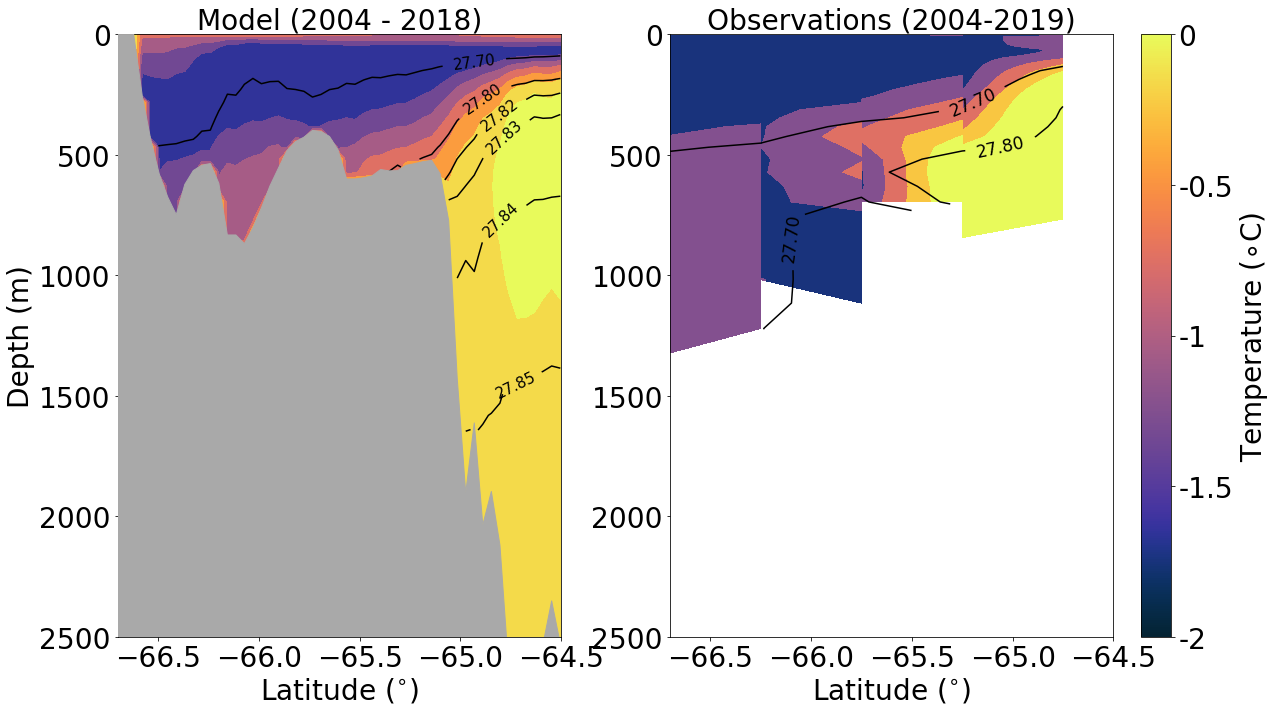

In [40]:
fontsize2 = 28
# choose density contours that work for your transect:
#density_contours = [27.7,27.8,27.83,27.84,27.85,27.9,28]
density_contours = [27.7,27.8,27.82,27.83,27.84,27.85,27.9,28]

# set up figure and projection:
fig = plt.figure(1,figsize=(18,10))
fig.subplots_adjust(top=0.88)

ax0 = plt.subplot(1, 2, 1) 
# plot temperature:
pcm = plt.contourf(temp_transect.yt_ocean, temp_transect.st_ocean, temp_transect.fillna(0),
           cmap = cmocean.thermal, vmin=-2, vmax=0)
pcm.set_clim(-2, 0)

plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:ww
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude ($^{\circ}$)',fontsize=fontsize2)
plt.title('Model (2004 - 2018)',fontsize=fontsize2)

#cbar=plt.colorbar()
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize2,labelpad=5)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

## plot density contours:
cont = plt.contour(sigma0.yt_ocean,sigma0.st_ocean,sigma0,density_contours,
           colors='k',zorder=2 ,fontsize=17)
plt.clabel(cont, inline=1, fontsize=15,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


ax1 = plt.subplot(1, 2, 2)   
# plot temperature:
pcm = plt.contourf(temp_transect_seal.lat_bin, temp_transect_seal.st_ocean, temp_transect_seal,
           cmap = cmocean.thermal, vmin=-2, vmax=0)

plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
#plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude ($^{\circ}$)',fontsize=fontsize2)
plt.title('Observations (2004-2019)',fontsize=fontsize2)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize2,labelpad=5)
# set the tick positions and labels for the second colorbar
ticks = [-2, -1.5, -1, -0.5, 0]
ticklabels = ['-2', '-1.5', '-1', '-0.5' ,'0']
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)

# plot density contours:
#cont = plt.contour(sigma0_seal.yt_ocean,sigma0_seal.st_ocean,sigma0_seal,[27.8],
#           colors='k',zorder=2 ,fontsize=17)
#cont = plt.contour(da_sigma_seal.yt_ocean,da_sigma_seal.st_ocean,da_sigma_seal,[27.7,27.8],
#           colors='k',zorder=2 ,fontsize=17)
cont = plt.contour(da.yt_ocean,da.st_ocean,da,[27.7,27.8],
           colors='k',zorder=1 ,fontsize=17)


plt.clabel(cont, inline=True, fontsize=17,fmt='%1.2f')

## this is for 0.1 add labels for 27.8 and 27.82 contours:
#plt.text(-65.3, 470, '27.80', rotation=-20, fontsize=15, color='k')
#plt.text(-65.58, 450, '27.80', rotation=20, fontsize=15, color='k')
#plt.text(-65.15, 360, '27.70', rotation=45, fontsize=15, color='k')
## don't plot land on the obs, bc seals indicate different bathymetry than the model anyway. 
#plt.fill_between(ht_transect_seal.yt_ocean,ht_transect_seal,6000,zorder=3,color='darkgrey')

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/SI_validation_transects_model_vs_seals_coarseT.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

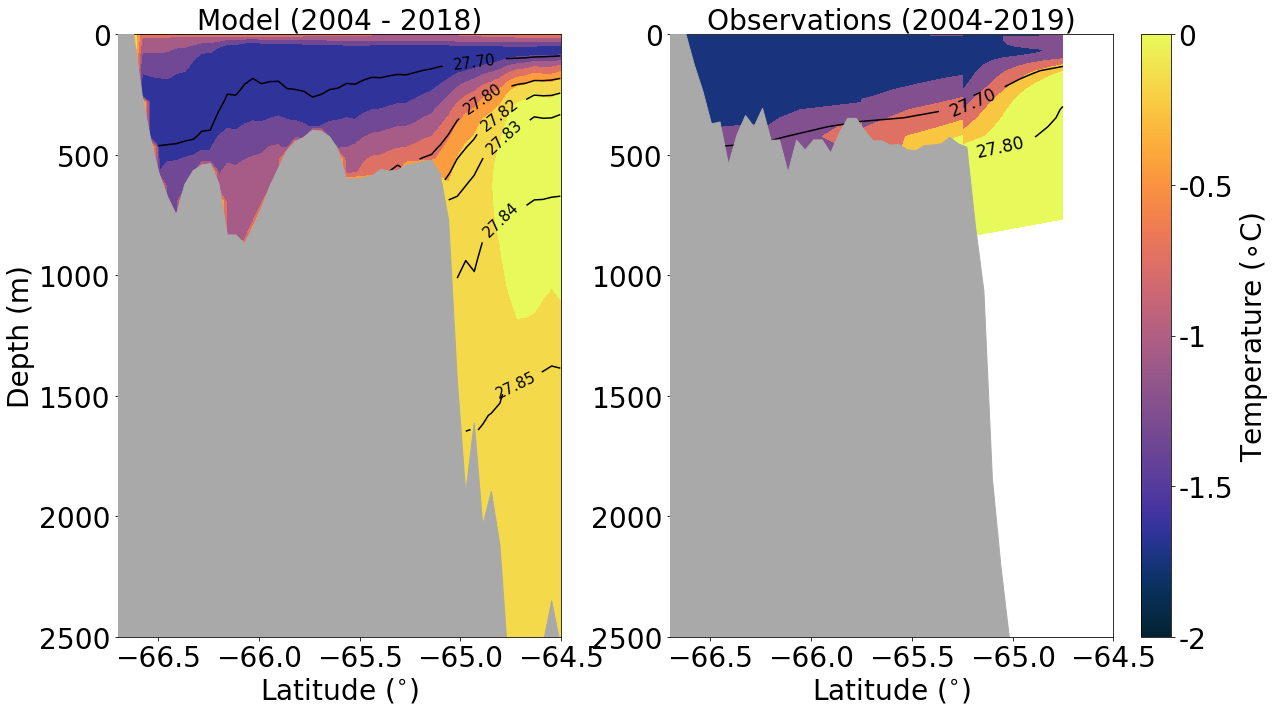

In [39]:
fontsize2 = 28
# choose density contours that work for your transect:
#density_contours = [27.7,27.8,27.83,27.84,27.85,27.9,28]
density_contours = [27.7,27.8,27.82,27.83,27.84,27.85,27.9,28]

# set up figure and projection:
fig = plt.figure(1,figsize=(18,10))
fig.subplots_adjust(top=0.88)

ax0 = plt.subplot(1, 2, 1) 
# plot temperature:
pcm = plt.contourf(temp_transect.yt_ocean, temp_transect.st_ocean, temp_transect.fillna(0),
           cmap = cmocean.thermal, vmin=-2, vmax=0)
pcm.set_clim(-2, 0)

plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:ww
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude ($^{\circ}$)',fontsize=fontsize2)
plt.title('Model (2004 - 2018)',fontsize=fontsize2)

#cbar=plt.colorbar()
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize2,labelpad=5)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

## plot density contours:
cont = plt.contour(sigma0.yt_ocean,sigma0.st_ocean,sigma0,density_contours,
           colors='k',zorder=2 ,fontsize=17)
plt.clabel(cont, inline=1, fontsize=15,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


ax1 = plt.subplot(1, 2, 2)   
# plot temperature:
pcm = plt.contourf(temp_transect_seal.lat_bin, temp_transect_seal.st_ocean, temp_transect_seal,
           cmap = cmocean.thermal, vmin=-2, vmax=0)

plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
#plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude ($^{\circ}$)',fontsize=fontsize2)
plt.title('Observations (2004-2019)',fontsize=fontsize2)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize2,labelpad=5)
# set the tick positions and labels for the second colorbar
ticks = [-2, -1.5, -1, -0.5, 0]
ticklabels = ['-2', '-1.5', '-1', '-0.5' ,'0']
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)

# plot density contours:
#cont = plt.contour(sigma0_seal.yt_ocean,sigma0_seal.st_ocean,sigma0_seal,[27.8],
#           colors='k',zorder=2 ,fontsize=17)
#cont = plt.contour(da_sigma_seal.yt_ocean,da_sigma_seal.st_ocean,da_sigma_seal,[27.7,27.8],
#           colors='k',zorder=2 ,fontsize=17)
cont = plt.contour(da.yt_ocean,da.st_ocean,da,[27.7,27.8],
           colors='k',zorder=1 ,fontsize=17)


plt.clabel(cont, inline=True, fontsize=17,fmt='%1.2f')

## this is for 0.1 add labels for 27.8 and 27.82 contours:
#plt.text(-65.3, 470, '27.80', rotation=-20, fontsize=15, color='k')
#plt.text(-65.58, 450, '27.80', rotation=20, fontsize=15, color='k')
#plt.text(-65.15, 360, '27.70', rotation=45, fontsize=15, color='k')
## don't plot land on the obs, bc seals indicate different bathymetry than the model anyway. 
plt.fill_between(ht_transect_seal.yt_ocean,ht_transect_seal,6000,zorder=3,color='darkgrey')

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/SI_validation_transect_model_vs_seals_coarse_with_bathy.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

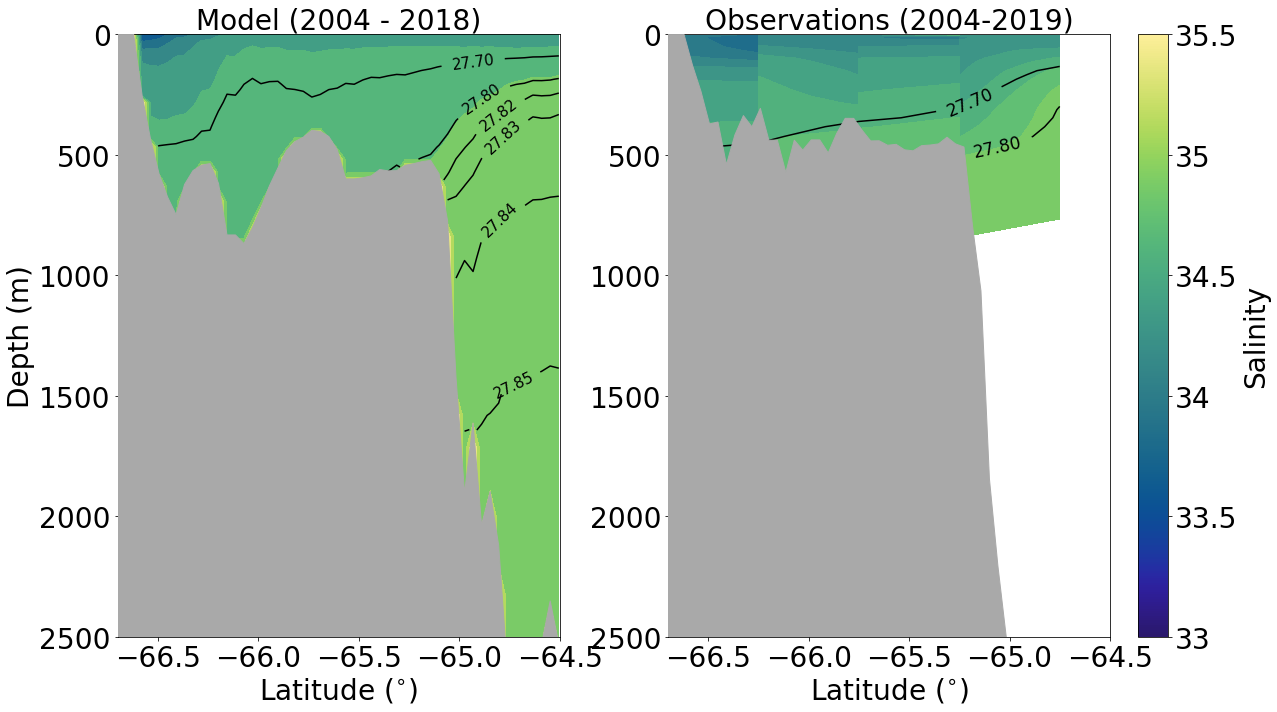

In [40]:
fontsize2 = 28
# choose density contours that work for your transect:
#density_contours = [27.7,27.8,27.83,27.84,27.85,27.9,28]
density_contours = [27.7,27.8,27.82,27.83,27.84,27.85,27.9,28]

# set up figure and projection:
fig = plt.figure(1,figsize=(18,10))
fig.subplots_adjust(top=0.88)

ax0 = plt.subplot(1, 2, 1) 
# plot temperature:
pcm = plt.contourf(sal_transect.yt_ocean, sal_transect.st_ocean, sal_transect.fillna(35.5),
           cmap = cmocean.haline, vmin=33, vmax=35.5)
plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:ww
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude ($^{\circ}$)',fontsize=fontsize2)
plt.title('Model (2004 - 2018)',fontsize=fontsize2)
#cbar=plt.colorbar()
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Salinity', fontsize = fontsize2,labelpad=5)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

## plot density contours:
cont = plt.contour(sigma0.yt_ocean,sigma0.st_ocean,sigma0,density_contours,
           colors='k',zorder=2 ,fontsize=17)
plt.clabel(cont, inline=1, fontsize=15,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


ax1 = plt.subplot(1, 2, 2)   
# plot temperature:
pcm = plt.contourf(sal_transect_seal.lat_bin, sal_transect_seal.st_ocean, sal_transect_seal,
           cmap = cmocean.haline, vmin=33, vmax=35.5)


plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
#plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude ($^{\circ}$)',fontsize=fontsize2)
plt.title('Observations (2004-2019)',fontsize=fontsize2)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Salinity', fontsize = fontsize2,labelpad=5)
# set the tick positions and labels for the second colorbar
ticks = [33, 33.5, 34, 34.5, 35, 35.5]
ticklabels = ['33', '33.5', '34', '34.5', '35', '35.5']
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)

# plot density contours:
#cont = plt.contour(sigma0_seal.yt_ocean,sigma0_seal.st_ocean,sigma0_seal,[27.8],
#           colors='k',zorder=2 ,fontsize=17)
#cont = plt.contour(da_sigma_seal.yt_ocean,da_sigma_seal.st_ocean,da_sigma_seal,[27.7,27.8],
#           colors='k',zorder=2 ,fontsize=17)
cont = plt.contour(da.yt_ocean,da.st_ocean,da,[27.7,27.8],
           colors='k',zorder=1 ,fontsize=17)


plt.clabel(cont, inline=True, fontsize=17,fmt='%1.2f')

## this is for 0.1 add labels for 27.8 and 27.82 contours:
#plt.text(-65.3, 470, '27.80', rotation=-20, fontsize=15, color='k')
#plt.text(-65.58, 450, '27.80', rotation=20, fontsize=15, color='k')
#plt.text(-65.15, 360, '27.70', rotation=45, fontsize=15, color='k')
## don't plot land on the obs, bc seals indicate different bathymetry than the model anyway. 
plt.fill_between(ht_transect_seal.yt_ocean,ht_transect_seal,6000,zorder=3,color='darkgrey')

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/SI_validation_transects_model_vs_seals_coarse_with_bathy_SALT.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

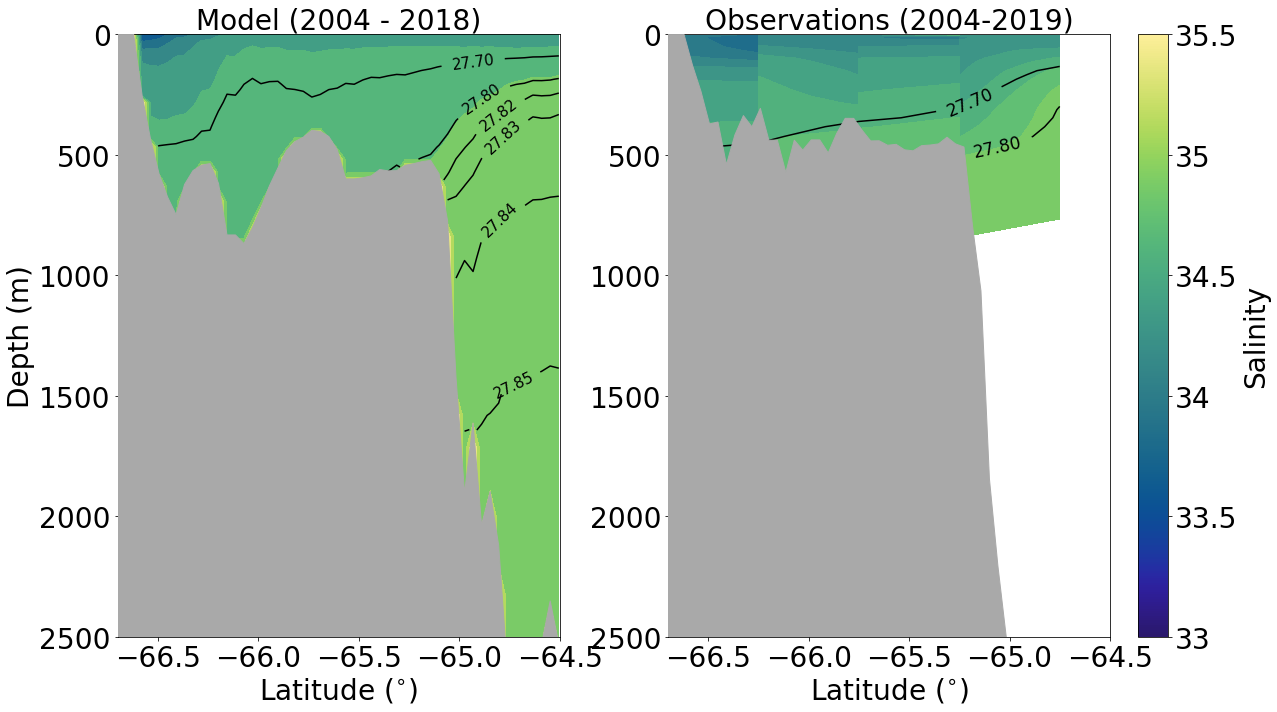

In [41]:
fontsize2 = 28
# choose density contours that work for your transect:
#density_contours = [27.7,27.8,27.83,27.84,27.85,27.9,28]
density_contours = [27.7,27.8,27.82,27.83,27.84,27.85,27.9,28]

# set up figure and projection:
fig = plt.figure(1,figsize=(18,10))
fig.subplots_adjust(top=0.88)

ax0 = plt.subplot(1, 2, 1) 
# plot temperature:
pcm = plt.contourf(sal_transect.yt_ocean, sal_transect.st_ocean, sal_transect.fillna(35.5),
           cmap = cmocean.haline, vmin=33, vmax=35.5)
plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:ww
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude ($^{\circ}$)',fontsize=fontsize2)
plt.title('Model (2004 - 2018)',fontsize=fontsize2)
#cbar=plt.colorbar()
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Salinity', fontsize = fontsize2,labelpad=5)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

## plot density contours:
cont = plt.contour(sigma0.yt_ocean,sigma0.st_ocean,sigma0,density_contours,
           colors='k',zorder=2 ,fontsize=17)
plt.clabel(cont, inline=1, fontsize=15,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


ax1 = plt.subplot(1, 2, 2)   
# plot temperature:
pcm = plt.contourf(sal_transect_seal.lat_bin, sal_transect_seal.st_ocean, sal_transect_seal,
           cmap = cmocean.haline, vmin=33, vmax=35.5)


plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
#plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude ($^{\circ}$)',fontsize=fontsize2)
plt.title('Observations (2004-2019)',fontsize=fontsize2)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar = fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Salinity', fontsize = fontsize2,labelpad=5)
# set the tick positions and labels for the second colorbar
ticks = [33, 33.5, 34, 34.5, 35, 35.5]
ticklabels = ['33', '33.5', '34', '34.5', '35', '35.5']
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)

# plot density contours:
#cont = plt.contour(sigma0_seal.yt_ocean,sigma0_seal.st_ocean,sigma0_seal,[27.8],
#           colors='k',zorder=2 ,fontsize=17)
#cont = plt.contour(da_sigma_seal.yt_ocean,da_sigma_seal.st_ocean,da_sigma_seal,[27.7,27.8],
#           colors='k',zorder=2 ,fontsize=17)
cont = plt.contour(da.yt_ocean,da.st_ocean,da,[27.7,27.8],
           colors='k',zorder=1 ,fontsize=17)


plt.clabel(cont, inline=True, fontsize=17,fmt='%1.2f')

#plot land
#plt.fill_between(ht_transect_seal.yt_ocean,ht_transect_seal,6000,zorder=3,color='darkgrey')

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/SI_validation_transect_model_vs_seals_coarse_SALT.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')